# Demo de Deep Autoencoder (DAE) con imágenes
Basado en:

https://blog.keras.io/building-autoencoders-in-keras.html


https://towardsdatascience.com/deep-autoencoders-using-tensorflow-c68f075fd1a3

In [1]:
#@title Librerías a usar
from tensorflow import keras
from keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.utils import to_categorical

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import random
import copy
import math

import ipywidgets as widgets
from ipywidgets import Box, Layout

import cv2
from PIL import Image

import os
import csv

print("\nLibrerías importadas")


Librerías importadas


# Imágenes:

In [3]:
#@title Acceder al Drive

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# directorio local en Google Drive
path = 'gdrive/My Drive/IA/demoML/imagenes/NUMEROS' #@param {type:"string"}
path_entrenamiento = '/train'  #@param {type:"string"}
path_prueba = '/test'  #@param {type:"string"}

imagPath_train = path + path_entrenamiento
imagPath_test = path + path_prueba

Mounted at /content/gdrive


> Para Entrenamiento: 
- Clases cargadas:  10
- Imágenes cargadas:  240
- Ejemplo  0   (32, 32, 3) : 


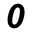



> Para Prueba: 
- Clases cargadas:  10
- Imágenes cargadas:  60
- Ejemplo  0   (32, 32, 3) : 


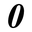

In [4]:
#@title Cargar imágenes

#@markdown ### Parámetros para imágenes:
imagen_ancho =  32#@param {type:"integer"}
imagen_largo =  32#@param {type:"integer"}
imagen_color = True #@param {type:"boolean"}

# tamaño de las imágenes
if imagen_ancho<=10:
  imagen_largo = 10
if imagen_largo<=10:
  imagen_largo = 10
IMAGE_SHAPE = (imagen_ancho, imagen_largo, (3 if imagen_color else 1))

# define función para cargar las imágenes
def cargarImagenes(imagPath):
  classes_ori = []
  images_ori = []

  all_dirs = os.listdir( imagPath )
  for each_dir in all_dirs:

      auxiPath = imagPath + '/' + each_dir
      imagFN  = os.listdir( auxiPath )
      for each_imagFN in imagFN:


            # abre la imagen
            imag = Image.open(auxiPath + "/" + each_imagFN)

            # ajusta el tamaño
            if IMAGE_SHAPE[2]==1:
              tipoImage = 'L'
            else:
              tipoImage = 'RGB'
            imag = imag.convert(tipoImage)
            imag = imag.resize((IMAGE_SHAPE[0], IMAGE_SHAPE[1]), Image.LANCZOS)

            # transforma a un vector de nros
            arImag = np.array(imag)

            # agrega a los vectores
            classes_ori.append( each_dir )
            images_ori.append( arImag )

  return classes_ori, images_ori, tipoImage

# carga las imagenes de entrenamiento
classes_train, images_train, tipoImage_train = cargarImagenes(imagPath_train)
print("> Para Entrenamiento: ")
print("- Clases cargadas: ", len(np.unique(classes_train)))
print("- Imágenes cargadas: ", len(classes_train))

if len(classes_train)>0:
  print("- Ejemplo ", classes_train[0], " ", images_train[0].shape, ": ")
  display( Image.fromarray(images_train[0], tipoImage_train) )

# carga las imagenes de prueba
classes_test, images_test, tipoImage_test = cargarImagenes(imagPath_test)
print("\n\n> Para Prueba: ")
print("- Clases cargadas: ", len(np.unique(classes_test)))
print("- Imágenes cargadas: ", len(images_test))

if len(classes_test)>0:
  print("- Ejemplo ", classes_test[0], " ", images_test[0].shape, ": ")
  display( Image.fromarray(images_test[0], tipoImage_test) )

In [5]:
#@title Ajustar imágenes para reducir el fondo (opcional)

accion_realizar = "-" #@param ["-", "Blur Fondo", "Eliminar Fondo y pasar a Negro", "Eliminar Fondo y pasar a Blanco"]

def cambiarColorNegro(img, nuevoColor=[255, 255, 255]):
    black_pixels = np.where(
        (img[:, :, 0] == 0) &
        (img[:, :, 1] == 0) &
        (img[:, :, 2] == 0)
    )
    img[black_pixels] = nuevoColor
    return img

def blurFondoImagen(im):
  # Convert to the HSV color space
  hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
  # aplica filtro Otsu threshold para obtener máscara
  ret, maskthresh = cv2.threshold(hsv[:,:,0], 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  # Genera la máscara negada
  maskthresh = 255 - maskthresh
  # We need a to copy the mask 3 times to fit the frames
  maskthresh = np.repeat(maskthresh[:, :, np.newaxis], 3, axis=2)
  #  Create a blurred frame using Gaussian blur
  blurred_frame = cv2.GaussianBlur(im, (25, 25), 0)
  # Combine the original with the blurred frame based on mask
  return np.where(maskthresh == (255, 255, 255), im, blurred_frame)

def reducirFondoImagen(im):
  # aplica filtro Hue
  imhsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
  # aplica filtro Otsu threshold para obtener máscara
  ret, maskthresh = cv2.threshold(imhsv[:,:,0], 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  # Genera la máscara negada
  maskthresh = 255 - maskthresh
  # aplica la máscara sobre la imagen
  imgfin = cv2.bitwise_and(im, im, mask = maskthresh)
  return imgfin

def procesarImgRedFondo(imgList):
  nList = []
  for im in imgList:
    if accion_realizar == "Blur Fondo":
      # hacer blur del fondo
      imn = blurFondoImagen(im)
    elif accion_realizar == "Eliminar Fondo y pasar a Negro":
      # eliminar fondo y dejar negro
      imn = reducirFondoImagen(im)
    elif accion_realizar == "Eliminar Fondo y pasar a Blanco":
        # cambia fondo negro a casi negro
        # (para que no cambié después)
        imn = cambiarColorNegro(im, [0, 0, 1])
        # eliminar fondo
        imn = reducirFondoImagen(imn)
        # cambiar fondo a blanco
        imn = cambiarColorNegro(imn, [255, 255, 255])
    else:
      print("Acción no definida!")
      break
    nList.append( imn )
  return nList


# degermina si hace algo o no
if accion_realizar != "-":
  # aplica filtros para intentar reducir el fondo de la imagen
  # cambiando las imágenes disponibles
  images_train = procesarImgRedFondo(images_train)
  images_test = procesarImgRedFondo(images_test)

  if len(classes_train)>0:
    print("- Ejemplo Entrenamiento con fondo reducido ", classes_train[0], " ", images_train[0].shape, ": ")
    display( Image.fromarray(images_train[0], tipoImage_train) )

  if len(classes_test)>0:
    print("- Ejemplo Prueba con fondo reducido ", classes_test[0], " ", images_test[0].shape, ": ")
    display( Image.fromarray(images_test[0], tipoImage_test) )

> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (240, 3072)
 - y_trainEnc (cant):  240
 - y_train (cant):  240


> Para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (60, 3072)
 - y_testEnc (cant):  60
 - y_test (cant):  60


> Para Ambos: 
 - dictMapeo:  {'5': 0, '0': 1, '6': 2, '7': 3, '9': 4, '8': 5, '1': 6, '3': 7, '4': 8, '2': 9}
 - CLASES:  ['5', '0', '6', '7', '9', '8', '1', '3', '4', '2']

 - Imagen reconstruida de  0 ( 1  /  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] )


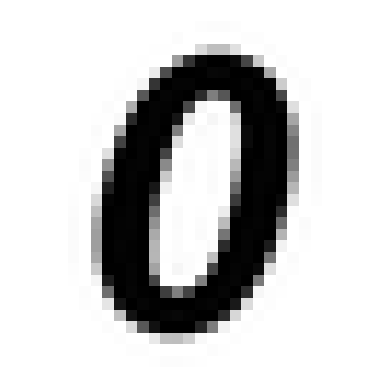

In [6]:
#@title Preparar imágenes para usar en el modelo

#@title Preparar imágenes

def agregarRuidoImagen(x_datos, gradoRuido_ori):
  # copia datos para no cambiar original
  x_datos = copy.deepcopy(x_datos)
  # si no se define ruido, no hace nada
  if gradoRuido_ori==0:
    return x_datos
  new_x_datos = []
  for x in x_datos:
    # si es negativo, determina el grado al azar por cada imagen
    if gradoRuido_ori < 0:
      gradoRuido = random.randint(0, 100)
    else:
      gradoRuido = gradoRuido_ori
    # agrega ruido al azar
    x = x + np.random.normal(loc=0.0, scale=gradoRuido/100, size=x.shape)
    x = np.clip(x, 0., 1.)
    new_x_datos.append( x )
  return np.array(new_x_datos)

# define función auxiliar para mostrar imágenes preparadas
def plot_image(imag):
  if IMAGE_SHAPE[2]==1:
    plt.imshow((imag*255).reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1]).astype(np.uint8))
    plt.gray()
  else:
    plt.imshow((imag*255).reshape(IMAGE_SHAPE).astype(np.uint8))
  plt.axis("off")

# define función auxiliar para preparar la lista de imágenes a procesar
def prepare_imageList(imagList, normValores=True):
  auxiAr = np.array(imagList)
  if normValores:
    auxiAr = auxiAr.astype('float32') / 255.
  auxiAr = auxiAr.reshape((len(auxiAr), num_inputs))
  return np.array(auxiAr)

# define vector auxiliar de datos de entrada para usar en el entrenamiento y prueba
num_inputs = IMAGE_SHAPE[0]*IMAGE_SHAPE[1]*IMAGE_SHAPE[2]
x_train = prepare_imageList(images_train)
x_test = prepare_imageList(images_test)

# define función auxiliar para preparar lista de clases
def prepare_clasesList(classesList, dictMapeo=None):
  if dictMapeo==None:
    # genera diccionario de mapeo
    auxDict = list(set(classesList))
    dictMapeo = dict( zip( auxDict, range(len(auxDict)) ) )
  # realiza el mapeo
  y = []
  for cl in classesList:
      y.append( dictMapeo[cl] )
  # convierte valores numéricos a columnas de vaores binarios (i.e. one hot encoded)
  dummy_y = to_categorical(y)
  # devuelve
  return np.array(y), np.array(dummy_y), dictMapeo

# define vector auxiliar de datos de entrada para usar en el entrenamiento y prueba
x_train = prepare_imageList(images_train)
x_test = prepare_imageList(images_test)

# define vector auxiliar de datos de salida para usar en el entrenamiento y prueba
# también usa esta información para determinar la cantida de neuronas de salida
y_train, y_trainEnc, dictMapeo = prepare_clasesList(classes_train)
y_test, y_testEnc,_ = prepare_clasesList(classes_test, dictMapeo)

daLayers_modelo = []

# genera diccionario auxiliar para poder convertir de ID de clase a nombre de clase
CLASES = [ x for x, y in dictMapeo.items() ]

print("> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print(" - y_trainEnc (cant): ", len(y_trainEnc))
print(" - y_train (cant): ", len(y_train))
print("\n\n> Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
print(" - y_testEnc (cant): ", len(y_testEnc))
print(" - y_test (cant): ", len(y_test))
print("\n\n> Para Ambos: ")
print(" - dictMapeo: ", dictMapeo)
print(" - CLASES: ", CLASES)
if len(y_train)>0:
  print("\n - Imagen reconstruida de ", CLASES[y_train[0]],  "(", y_train[0], " / ", y_trainEnc[0], ")")
  plot_image(x_train[0])


# inicializa lista para ejemplos con ruido
x_ruido_train_in = []
x_ruido_train_out = []

> Ejemplos de imágenes con ruido: 

> Se agregaron IN: 240 / OUT: 240  imágenes con ruido para entrenamiento.



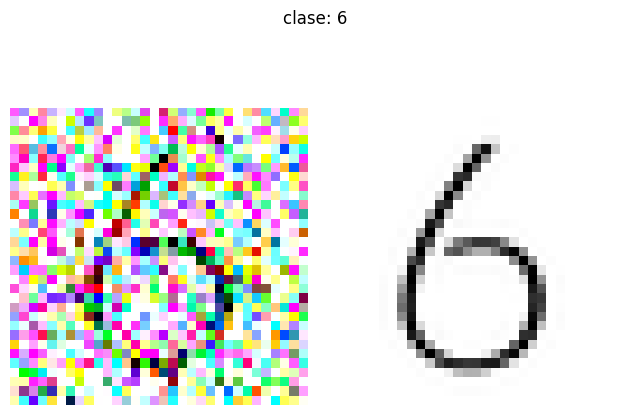

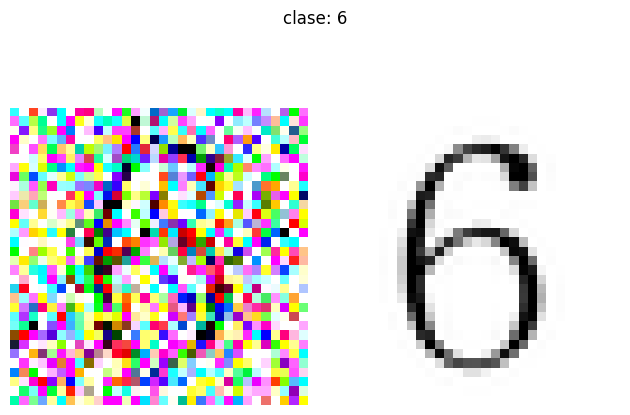

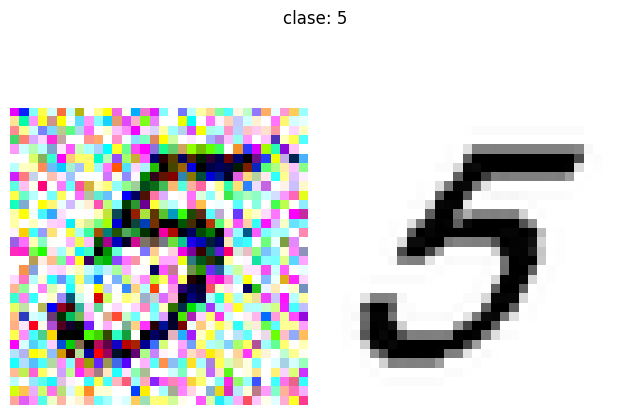

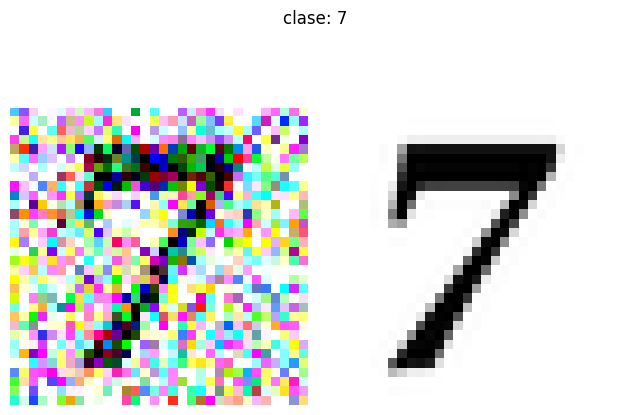

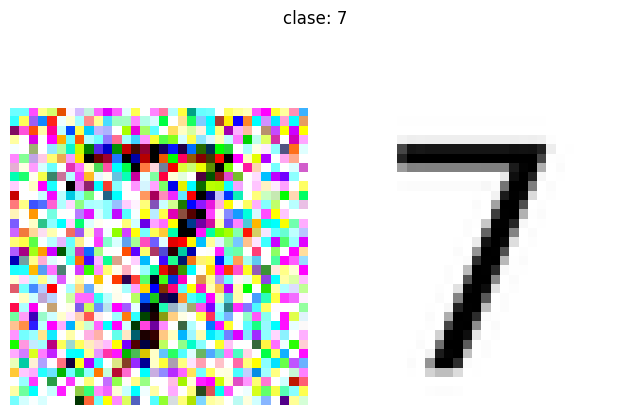

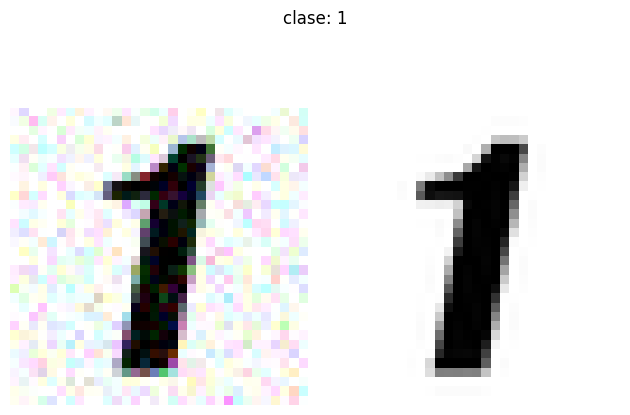

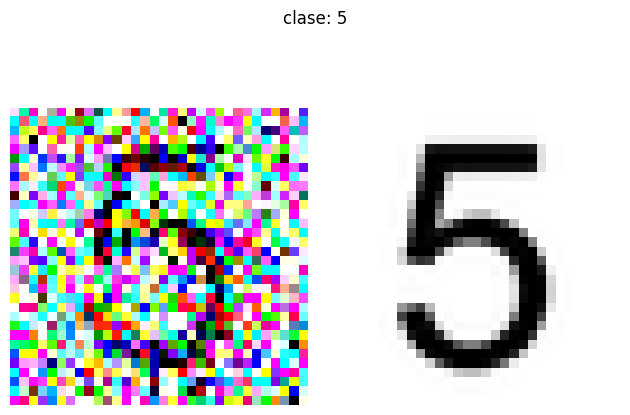

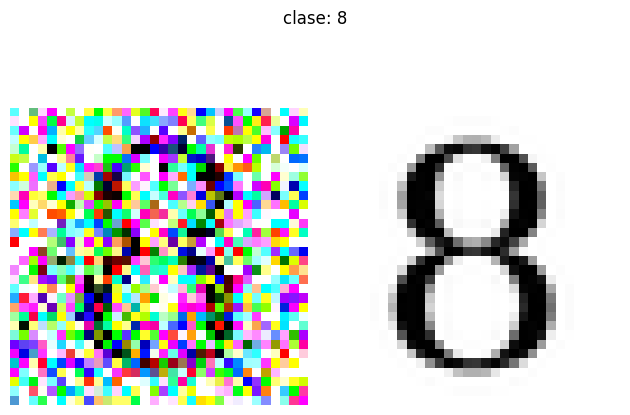

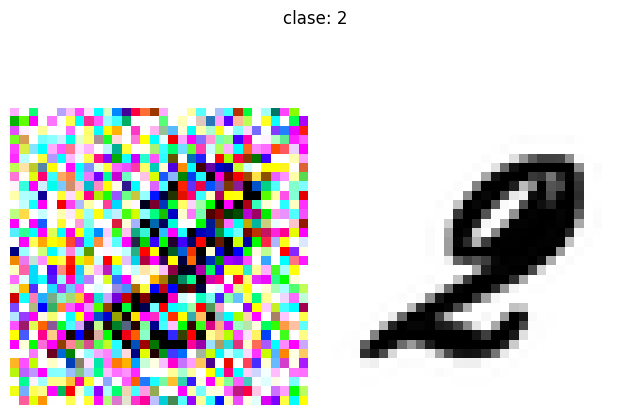

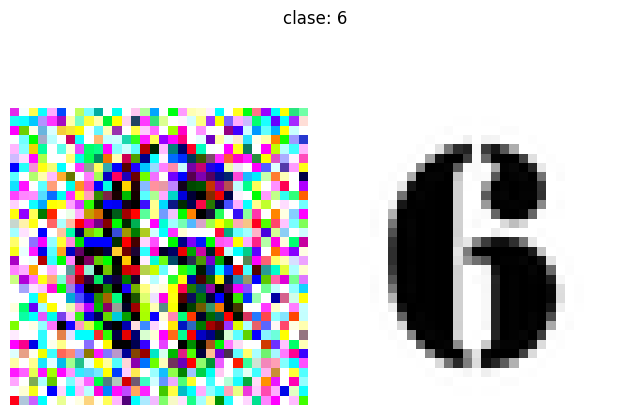

In [7]:
#@title Agregar ejemplos que tienen ruido al azar para entrenamiento

gradoRuidoImagenes_entrenamiento = -1 #@param {type:"slider", min:-1, max:100, step:1}
#@markdown (Nota: si se indica negativo, se determina un grado al azar)

if (len(x_train) > 0) and (gradoRuidoImagenes_entrenamiento != 0):
  # agrega ruido al azar
  x_nuevasRuido = agregarRuidoImagen(x_train, gradoRuidoImagenes_entrenamiento)
  x_ruido_train_in.extend( x_nuevasRuido )
  x_ruido_train_out.extend( x_train)
  print("> Ejemplos de imágenes con ruido: ")
  for _ in range(10):
      # elige al azar
      posAzar = random.randint(0, len(x_nuevasRuido)-1)
      # prepara para mostrar
      fig = plt.figure()
      fig.suptitle( "clase: " + str( CLASES[y_train[posAzar]] ) )

      # muestra la real
      ax1 = fig.add_subplot(122)
      plot_image( x_train[posAzar] )

      # muestra la imagen con ruido
      ax2 = fig.add_subplot(121)
      plot_image( x_nuevasRuido[posAzar] )

      plt.tight_layout()
      fig = plt.gcf()

  print("\n> Se agregaron IN:", len(x_ruido_train_in), "/ OUT:", len(x_ruido_train_out), " imágenes con ruido para entrenamiento.\n")
else:
  print("\n> No se agregan imágenes con ruido para entrenamiento.\n")

---
# Modelo Deep AutoEncoder:


Modelo DAE creado con  15  capas:


Model: "DAE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_data (InputLayer)              │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ enc_1 (Dense)                        │ (None, 512)                 │       1,573,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ enc_1_dp (Dropout)                   │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ enc_2 (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ enc_2_dp (Dropout)                   │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ enc_3 (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ enc_3_dp (Dropout)                   │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ enc_4 (Dense)                        │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ enc_4_dp (Dropout)                   │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ features (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dec_4 (Dense)                        │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dec_3 (Dense)                        │ (None, 64)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dec_2 (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dec_1 (Dense)                        │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_data (Dense)                  │ (None, 3072)                │       1,575,936 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,300,008 (12.59 MB)

 Trainable params: 3,300,008 (12.59 MB)

 Non-trainable params: 0 (0.00 B)

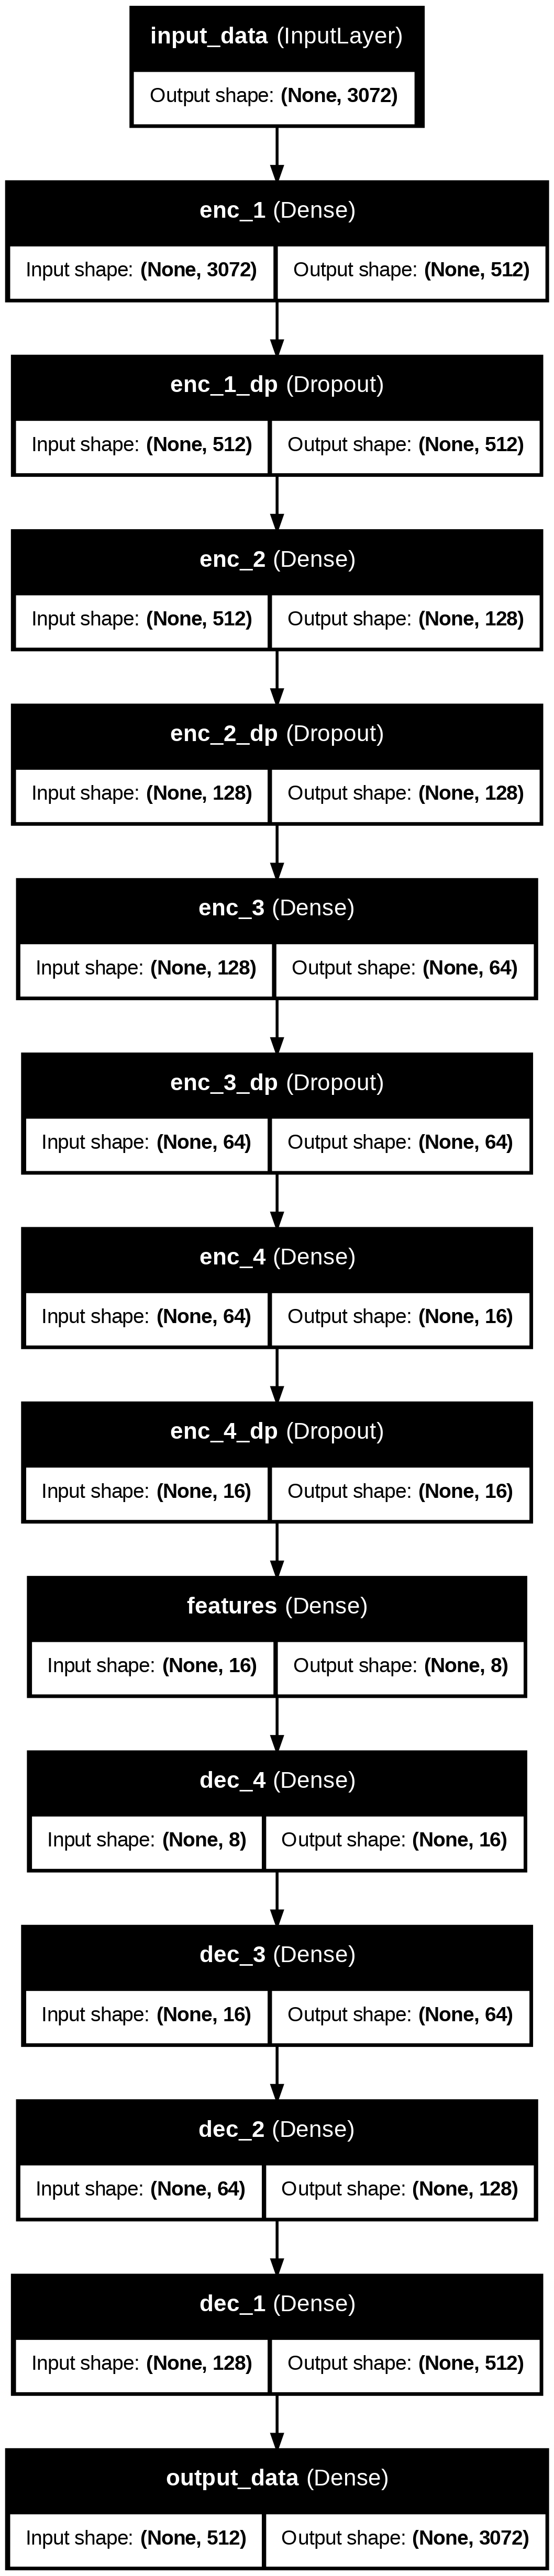

In [8]:
#@title Establecer el modelo DAE

#@markdown ### Parámetros de la Red:
rna_cant_neuronas_capas_ocultas = '512, 128, 64, 16' #@param {type:"string"}
rna_neuronas_funcion_activacion = "relu" #@param ["linear", "relu", "sigmoid", "tanh"]
rna_cant_neuronas_capa_features = 8 #@param {type:"integer"}

#@markdown ### Parámetros para ayudar aprender a capas Encoder:
rna_valor_L1_activity_regularizer = False #@param {type:"boolean"}
#@markdown (Nota: si se indica verdadero, se agrega la restricción de las representaciones para que sean compactas en capas de Encoders - nunca en Decoders)

rna_porc_capa_DropOut = 0.1 #@param {type:"number"}
#@markdown (Nota: si se indica valor mayor a cero, se agregan capas DropOut en capas de Encoders - nunca en Decoders)

#@markdown ### Parámetros del Optimizador:
opt_tipo = "Nadam" #@param ["Gradiente Decreciente", "Adam", "Adadelta", "Adagrad", "Adamax", "Nadam", "FTRL"]
opt_learning_rate = 0.001 #@param {type: "number"}

# define tamaño de datos de entrada y salida
num_outputs = num_inputs

# cantidad de neuronas ocultas para features (datos comprimidos o codings)
if rna_cant_neuronas_capa_features < 1:
  num_features = 1
else:
  num_features = rna_cant_neuronas_capa_features


if opt_tipo == "Gradiente Decreciente":
  opt = keras.optimizers.SGD(learning_rate=opt_learning_rate)
elif opt_tipo == "Adam":
  opt = keras.optimizers.Adam(learning_rate=opt_learning_rate)
elif opt_tipo == "Adadelta":
  opt = keras.optimizers.Adadelta(learning_rate=opt_learning_rate)
elif opt_tipo == "Adagrad":
  opt = keras.optimizers.Adagrad(learning_rate=opt_learning_rate)
elif opt_tipo == "Adamax":
  opt = keras.optimizers.Adamax(learning_rate=opt_learning_rate)
elif opt_tipo == "Nadam":
  opt = keras.optimizers.Nadam(learning_rate=opt_learning_rate)
elif opt_tipo == "FTRL":
  opt = keras.optimizers.Ftrl(learning_rate=opt_learning_rate)
else:
  opt = keras.optimizers.Adam()


# cantidad de neuronas ocultas para la parte Encoder
#   (cada elemento de la lista es la cantidad de pesos que tiene cada una)
dae_layers = []
for val in rna_cant_neuronas_capas_ocultas.split(','):
  val = val.strip()
  dae_layers.append( int(val) )

#  agrega la capa de features a las capas
dae_layers.append( num_features )

# cantidad de neuronas ocultas para la parte Decoder
#   (usa la la lista de Encoder inversa)
for eachEncLayer in dae_layers[0:len(dae_layers)-1][::-1]:
  dae_layers.append( eachEncLayer )

if rna_porc_capa_DropOut > 0.9:
  rna_porc_capa_DropOut = 0.9

# define la arquitectura de capas del Deep Autoencoder
# teniendo en cuenta la definición dada anteriomente
input_data_Lay = tf.keras.layers.Input(shape=(num_inputs,), name='input_data') # capa de entrada
eachLay = input_data_Lay
auxName = 'enc_'
auxId = 1
for num_hid in dae_layers:

    # define el nombre de la capa oculta
    actReg_Dense = None
    if num_features==num_hid:
        # capa tipo Features
        auxlayerName = 'features'
        auxName = 'dec_'
        auxId = auxId - 1
    else:
        auxlayerName = auxName+str(auxId)
        if auxName == 'enc_':
          # capa tipo Encoder
          auxId = auxId + 1
          if rna_valor_L1_activity_regularizer:
            # agrega regulizer
            actReg_Dense = tf.keras.regularizers.l1(10e-5)
        else:
          # capa tipo Decoder
          auxId = auxId - 1

    # agrega la capa oculta
    eachLay = tf.keras.layers.Dense(num_hid,
                                    activation = rna_neuronas_funcion_activacion,
                                    activity_regularizer = actReg_Dense,
                                    name = auxlayerName)(eachLay) # capas ocultas

    if num_features==num_hid:
      # guarda capa Features
      features_Lay = eachLay

    # agrega capa Drop si es Encoder y se indica probabilidad > 0
    if (rna_porc_capa_DropOut>0.0) and (auxName == 'enc_'):
      eachLay = tf.keras.layers.Dropout(rna_porc_capa_DropOut,
                                        name = auxlayerName+"_dp")(eachLay)

##if imagen_color:
##rna_salida_funcion_activacion = "tanh"
##else:
rna_salida_funcion_activacion = "sigmoid"

# capa de salida
output_data_Lay = tf.keras.layers.Dense(num_outputs,
                                         activation = rna_salida_funcion_activacion,
                                         name='output_data')(eachLay) # capa de salida

# genera el modelo Deep Autoencoder
DAEmodel = Model(input_data_Lay, output_data_Lay, name='DAE')

# dependiendo de la función de la capa de salida y si son imágenes con color
# determinar cómo se calcula el loss
if imagen_color and (rna_salida_funcion_activacion == "sigmoid"):
  lossFunc = "mse"
else:
   lossFunc = "binary_crossentropy"


DAEmodel.compile(optimizer=opt, loss=lossFunc, metrics=['RootMeanSquaredError'])

print("Modelo DAE creado con ", len(DAEmodel.layers), " capas:")
DAEmodel.summary()
print("\n")
plot_model(DAEmodel, show_layer_names=True, show_shapes=True)


In [9]:
#@title Entrenar DAE

cant_epocas_entrenamiento = 3000 #@param {type:"integer"}

# cantidad de épocas del entrenamiento
cantEpocas = (1 if cant_epocas_entrenamiento<1 else cant_epocas_entrenamiento)

# inicializa listtas auxiliares para entrenar
x_train_in = list( copy.deepcopy(x_train) )
x_train_out = list( copy.deepcopy(x_train) )

# si hay datos con ruido para agregar
if not(x_ruido_train_in is None) and (len(x_ruido_train_in)>0) and not(x_ruido_train_out is None) and (len(x_ruido_train_out)>0):
  x_train_in.extend( x_ruido_train_in )
  x_train_out.extend( x_ruido_train_out )

# prepara para que lo pueda usar el modelo
# (no se vuelven a normalizar los valores porque ya lo están)
x_train_in = prepare_imageList( x_train_in, False )
x_train_out = prepare_imageList( x_train_out, False )

print("-- Cantidad de ejemplos para entrenar: ",  x_train_in.shape, "/", x_train_out.shape, "\n")

# determina datos para entrenar
# lleva a cabo el entrenamiento
history = DAEmodel.fit(x_train_in, x_train_out,
                epochs = cantEpocas,
                shuffle = True)


Se han truncado las últimas 5000 líneas del flujo de salida.
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - RootMeanSquaredError: 0.1034 - loss: 0.0107
Epoch 502/3000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - RootMeanSquaredError: 0.1107 - loss: 0.0123
Epoch 503/3000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - RootMeanSquaredError: 0.1004 - loss: 0.0101
Epoch 504/3000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - RootMeanSquaredError: 0.1095 - loss: 0.0120
Epoch 505/3000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - RootMeanSquaredError: 0.1078 - loss: 0.0116
Epoch 506/3000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - RootMeanSquaredError: 0.1047 - loss: 0.0110
Epoch 507/3000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - RootMeanSquaredError: 0.1017 - loss: 0.0103
Epoch 508/3000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - RootMeanSquaredError: 0.1074 - loss: 0.0115
Epoch 509/3000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - RootMeanSquaredError: 0.1009 - loss: 0.0102
Epoch 510/3000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

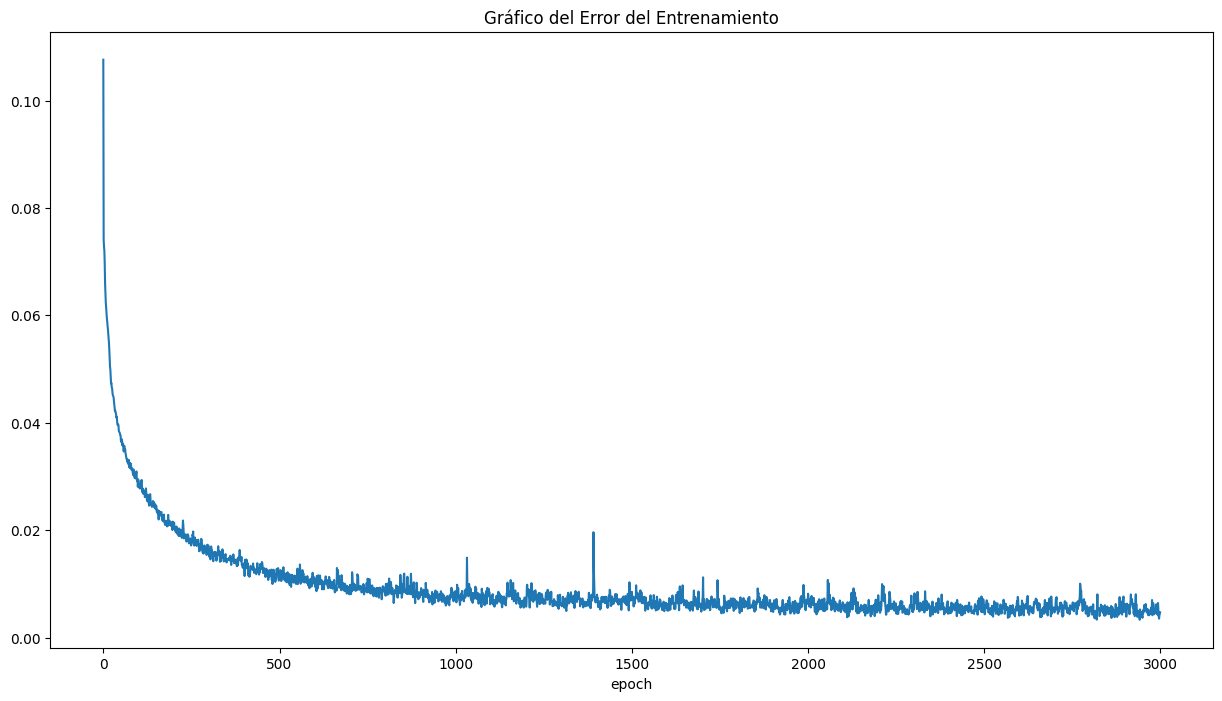

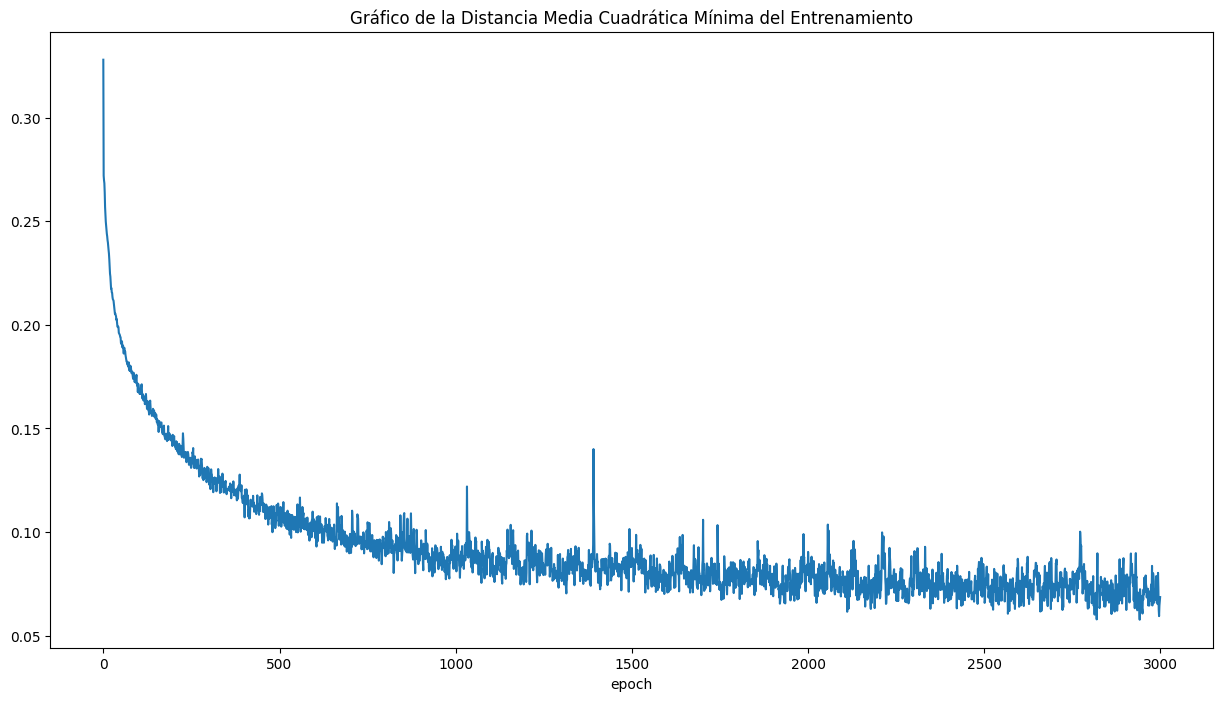

In [10]:
#@title Mostrar Gráficos del Entrenamiento
plt.figure(figsize=(15,8))
plt.plot(history.history['loss'])
plt.title('Gráfico del Error del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.show()

plt.figure(figsize=(15,8))
plt.plot(history.history['RootMeanSquaredError'])
plt.title('Gráfico de la Distancia Media Cuadrática Mínima del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.show()

In [11]:
#@title Evaluar el modelo con las imágenes de entrenamiento

# para sacar warning por cantidad de imágenes mostradas
plt.rcParams.update({'figure.max_open_warning': 0})

# función auxiliar para probar el modelo entrenado en detalle
def probarModelo_DAE(x, y, claseFiltrar=None, cantMostrar=6, gradoRuido=0):

  # determina clase a filtrar
  if (claseFiltrar is None) or (claseFiltrar == "TODOS"):
        clFiltrarID = None
  else:
        clFiltrarID = dictMapeo[claseFiltrar]

  if cantMostrar<0:
    cantMostrar = 3

  # agrega ruido según corresponda
  if gradoRuido == 0:
    x_in = x
  else:
    x_in = agregarRuidoImagen(x, gradoRuido)

  # procesa las imágenes con el modelo
  reconstr_imgs = DAEmodel.predict(x_in, verbose=0)
  cantMostradas = 0
  posIm = 0
  for i in range(cantMostrar):
      # elige al azar o no para mostrar
      if clFiltrarID is None:
        posIm = random.randint(1, len(x))-1
      else:
        while (posIm < len(x)) and (clFiltrarID != y[posIm]):
          posIm += 1
        if posIm >= len(x):
          break

      # prepara para mostrar
      fig = plt.figure()
      fig.suptitle( "clase: " + str( CLASES[y[posIm]] ) )

      # muestra la real
      ax1 = fig.add_subplot(121)
      plot_image( x_in[posIm] )

      # muestra la generada por el modelo
      ax2 = fig.add_subplot(122)
      plot_image( reconstr_imgs[posIm] )

      plt.tight_layout()
      fig = plt.gcf()
      cantMostradas = cantMostradas + 1
      posIm = posIm + 1
  print("\n\t Cantidad imágenes mostradas: ", cantMostradas, "\n")
  plt.show()

# genera toda la interface para evaluar modeo DAE
def crearUI_evaluarModeloDAE(clDefecto, ruidoPorDefecto, funcionCambiaSeleccion):
  # prepara combo para filtrar por clase
  seleccion_CLASES = ["-", "TODOS"]
  seleccion_CLASES.extend( CLASES )
  seleccion_CLASES.sort()

  # auxiliar para que muestre bien la descripción
  style_3D = {'description_width': 'initial'}

  combo_clase = widgets.Dropdown(
      options = seleccion_CLASES,
      value = clDefecto,
      description = 'Filtrar por clase:',
      style=style_3D,
      disabled = False,
  )

  # prepara combo para filtrar por cantidad
  selecc_cantidad = [ 3 ]
  selecc_cantidad.extend( range(6, 151, 9) )
  selecc_cantidad.append( "TODAS" )
  combo_cantidad = widgets.Dropdown(
      options = selecc_cantidad,
      value = 6,
      description = 'Mostrar N imágenes al azar:',
      style=style_3D,
      disabled = False,
  )

  # prepara para seleccionar grado de ruido
  gradoRuidoImagenes = widgets.FloatSlider(
          value=ruidoPorDefecto,
          min=-1,
          max=100,
          step=1,
          description='Grado ruido para agregar:',
          style=style_3D,
          disabled=False,
          continuous_update=False,
          orientation='horizontal',
          readout=True,
          readout_format='.1f',)


  prueba_ui = widgets.GridBox(children=[combo_clase, combo_cantidad, gradoRuidoImagenes],
          layout=Layout(width='100%')
        )
  out_prueba = widgets.interactive_output(funcionCambiaSeleccion, {'cl':combo_clase, 'cant':combo_cantidad, 'r':gradoRuidoImagenes})

  return prueba_ui, out_prueba

# función para filtrar por clase
def cambiaSeleccion_clase_evaluar_imEntrenamiento(cl, cant, r):
  if (cl == "-"):
    return
  # prueba con los datos de entrenamiento
  print("*** Resultados con datos de Entrenamiento: clase "+cl)
  probarModelo_DAE(x_train, y_train, cl, cant, r)

# muestra la interface
ev_entrenamiento_ui, ev_entrenamiento_out = crearUI_evaluarModeloDAE( "TODOS", gradoRuidoImagenes_entrenamiento, cambiaSeleccion_clase_evaluar_imEntrenamiento )
display(ev_entrenamiento_ui, ev_entrenamiento_out)


GridBox(children=(Dropdown(description='Filtrar por clase:', index=11, options=('-', '0', '1', '2', '3', '4', …

Output()

In [12]:
#@title Evaluar el modelo con las imágenes de prueba

# función para filtrar por clase
def cambiaSeleccion_clase_evaluar_imPrueba(cl, cant, r):
  if (cl == "-"):
    return
  # prueba con los datos de entrenamiento
  print("*** Resultados con datos de Prueba: clase "+cl)
  probarModelo_DAE(x_test, y_test, cl, cant, r)

# muestra la interface
ev_prueba_ui, ev_prueba_out = crearUI_evaluarModeloDAE( "TODOS", gradoRuidoImagenes_entrenamiento, cambiaSeleccion_clase_evaluar_imPrueba )
display(ev_prueba_ui, ev_prueba_out)


GridBox(children=(Dropdown(description='Filtrar por clase:', index=11, options=('-', '0', '1', '2', '3', '4', …

Output()

In [13]:
#@title Guardar Modelo entrenado

guardar_modelo = True #@param{type:"boolean"}
path_modelo = '/content/gdrive/MyDrive/IA/demoML/modelos/ImagDAE'  #@param {type:"string"}

if guardar_modelo:

    import os

    # si no existe el directorio, lo crea
    if not os.path.isdir(path_modelo):
      os.makedirs(path_modelo)

    # guarda el modelo entrenado
    fn_model = path_modelo+"/model.keras"
    DAEmodel.save(fn_model)
    print("\n-Modelo guardado en ", fn_model,"\n")

    if ("IMAGE_SHAPE" in locals()) and (IMAGE_SHAPE is not None):
      fn_imageShape = path_modelo+"/IMAGE_SHAPE.txt"
      with open(fn_imageShape, 'w') as f:
        for i in IMAGE_SHAPE:
          f.write(str(i)+"\n")
      print("\n-IMAGE_SHAPE para cargar las imágenes guardado en ", path_modelo,"\n")


    if ("clases_map" in locals()) and (clases_map is not None):
      fn_clases = path_modelo+"/CLASES_MAP.txt"
      with open(fn_clases, 'w') as f:
        for i in range(len(clases_map)):
          f.write(str(i)+":"+str(clases_map[i])+"\n")
      print("\n-CLASES_MAP para mostrar los resultados guardado en ", path_modelo,"\n")

else:
    print("\n-Modelo no guardado.")


-Modelo guardado en  /content/gdrive/MyDrive/IA/demoML/modelos/ImagDAE/model.keras 


-IMAGE_SHAPE para cargar las imágenes guardado en  /content/gdrive/MyDrive/IA/demoML/modelos/ImagDAE 




# Sub-modelo Encoder:


In [14]:
#@title Generar el sub-modelo Encoder para Clustering
## (desde input hasta features)

# reutiliza las capas entrenadas del modelo DAE original
clust_input_Lay = input_data_Lay  # capa de entrada
clust_output_Lay =  features_Lay  # capa de salida

# genera el modelo
CLUSTmodel = Model(input_data_Lay, features_Lay, name='Encoder_Clustering')

print("> Modelo Encoder: ")
CLUSTmodel.summary()
#plot_model(CLUSTmodel, show_layer_names=True, show_shapes=True)

> Modelo Encoder: 


Model: "Encoder_Clustering"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_data (InputLayer)              │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ enc_1 (Dense)                        │ (None, 512)                 │       1,573,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ enc_1_dp (Dropout)                   │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ enc_2 (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ enc_2_dp (Dropout)                   │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ enc_3 (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ enc_3_dp (Dropout)                   │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ enc_4 (Dense)                        │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ enc_4_dp (Dropout)                   │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ features (Dense)                     │ (None, 8)                   │             136 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,648,472 (6.29 MB)

 Trainable params: 1,648,472 (6.29 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
 #@title Generar Clustering
  # Muestra estadísticas y gráfico de los datos codificados

# determina datos a usar
usarDatos = 'Datos Entrenamiento' #@param ["Datos Entrenamiento", "Datos de Prueba"] {allow-input: false}
if usarDatos == 'Datos Entrenamiento':
  datosUsar = x_train
  datosUsar_y = y_train
else:
  datosUsar = x_test
  datosUsar_y = y_test

# procesa los datos para recibir el valor codificado de cada una
x_encoded = CLUSTmodel.predict(datosUsar)

# calcula estadisticas
minArClust = np.empty(num_features)
minArClust.fill(9999.99)
maxArClust = np.empty(num_features)
maxArClust.fill(-9999.99)
sumArClust = np.zeros(num_features)
for val in x_encoded:
  for i in range(num_features):
      sumArClust[i] = sumArClust[i]+val[i]
      if val[i]<minArClust[i]:
          minArClust[i] = val[i]
      if val[i]>maxArClust[i]:
          maxArClust[i] = val[i]
print("\n\n> Estadísticas de Clutering de Datos Originales codificado en ", num_features," features: ")
print("- Mínimos:   ", minArClust)
print("- Máximos:   ", maxArClust)
print("- Totales:   ", sumArClust)
print("- Promedios: ", sumArClust/len(x_encoded))
print("\n\n")

if len(x_encoded)>0 and len(x_encoded[0])>0:

  import ipywidgets as widgets
  from ipywidgets import Box, Layout


  #colValues = range(len(x_encoded[0]))
  colValues = []
  for col in range(len(x_encoded[0])):
    colValues.append("feature_"+str(col))

  # agrega los combos
  comboColX = widgets.Dropdown(
      options=colValues,
      value=colValues[0],
      description='Columna X:',
      disabled=False,
  )
  if len(colValues)>1:
    valYsel = colValues[1]
  else:
    valYsel = colValues[0]

  comboColY = widgets.Dropdown(
      options=colValues,
      value=valYsel,
      description='Columna Y:',
      disabled=False,
  )


  ui = widgets.HBox([comboColX, comboColY])

  import matplotlib.ticker as ticker

  def fmtClases(x, pos):
    return CLASES[int(x)]

  def cambiaSeleccion(fx, fy):
    # llama a la función
    # para generar el gráfico con las columnas seleccionadas
    # muestra el gráfico codificado
    plt.figure(figsize=(16, 10))
    x = int(fx.replace("feature_", ""))
    y = int(fy.replace("feature_", ""))
    plt.scatter(x_encoded[:,x], x_encoded[:,y], c=datosUsar_y, cmap='jet')
    plt.colorbar(format=ticker.FuncFormatter(fmtClases))
    plt.grid(color='grey', which='major', axis='y', linestyle='solid', linewidth=0.3)
    plt.grid(color='grey', which='major', axis='x', linestyle='solid', linewidth=0.3)
    plt.title("Representación de Datos Clusterizados", fontsize = 20)
    plt.show()

  out = widgets.interactive_output(cambiaSeleccion, {'fx': comboColX, 'fy': comboColY})
  display(ui, out)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


> Estadísticas de Clutering de Datos Originales codificado en  8  features: 
- Mínimos:    [0. 0. 0. 0. 0. 0. 0. 0.]
- Máximos:    [155.72547913 480.16000366 509.47735596 531.95593262 233.89855957
 656.24755859  50.41246414 210.08981323]
- Totales:    [  702.10980712 17933.47922398 16413.2914112  18320.62573898
  8303.55405639 25875.73713706   875.87209958  4827.8918504 ]
- Promedios:  [  2.92545753  74.7228301   68.38871421  76.33594058  34.5981419
 107.8155714    3.64946708  20.11621604]





Output()

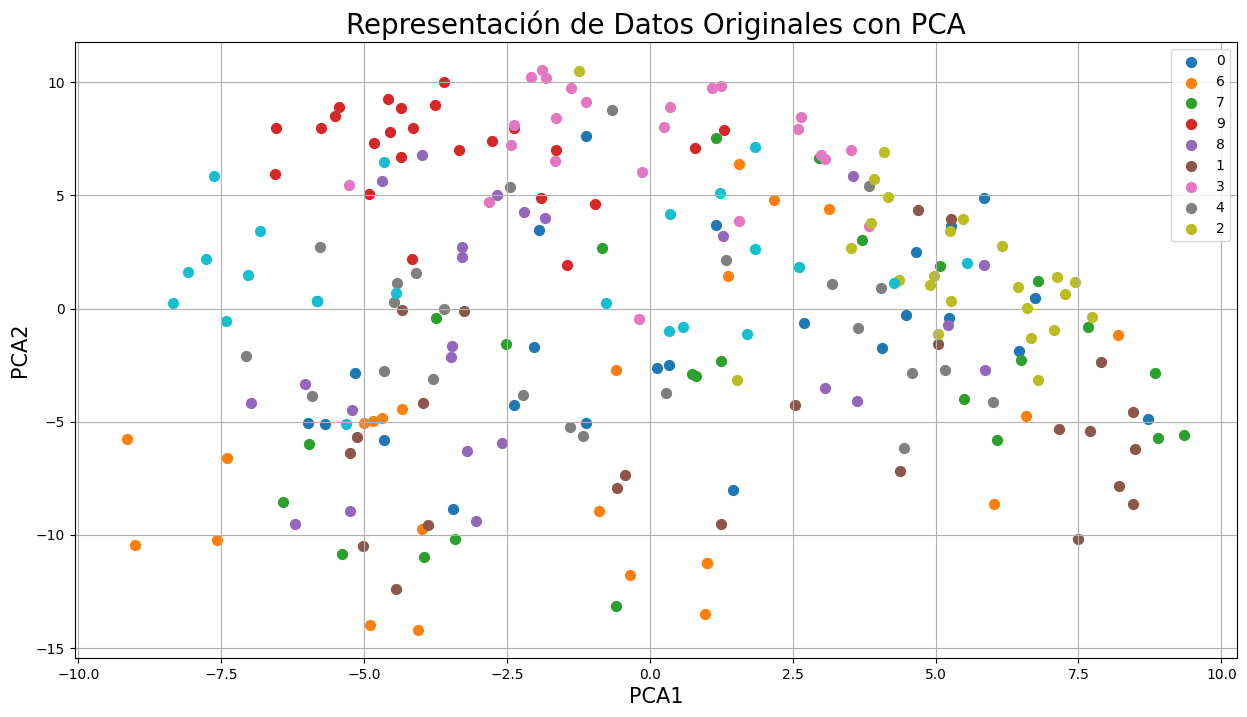

In [16]:
#@title Función auxiliar para generar gráfico PCA de comparación

# función auxiliar para generar un gráfico
# con los valores codificados
# usando PCA para simplificarlos en 2 ejes
def genera_grafico_pca(datos, clases, titulo):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(datos)
    principalDf = pd.DataFrame(data = principalComponents,
                columns = ['pca_1', 'pca_2'])
    finalDf = pd.concat([principalDf,
                        pd.DataFrame(clases, columns = ['target'])],
                        axis = 1)

    fig = plt.figure(figsize = (15,8))
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel('PCA1', fontsize = 15)
    ax.set_ylabel('PCA2', fontsize = 15)
    ax.set_title(titulo, fontsize = 20)
    for target in set(clases):
        indicesToKeep = finalDf['target'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'pca_2'],
                  finalDf.loc[indicesToKeep, 'pca_1'],
                  s = 50)
    ax.legend(CLASES[1:])
    ax.grid()


# muestra el gráfico con originales con PCA (para que tenga 2 dimensiones)
generar_grafico_PCA = True #@param{type:"boolean"}
if generar_grafico_PCA:
  genera_grafico_pca(datosUsar, datosUsar_y, "Representación de Datos Originales con PCA")


In [17]:
#@title Aplicar Algoritmo de Inducción usando como entrada valores de Features/Clusters

from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# función auxiliar para probar el modelo entrenado en detalle
def probarModelo_Inducc(clf, x, y, clases_map, mostrarDetalle=False):

    # procesa las imágenes de prueba con el modelo
    predClass = clf.predict(x)

    # muestra los resultados con las imágenes
    classPreds = []
    classReal = []
    for i in range(len(x)):

        # prepara salida
        clReal = y[i]
        clPred = predClass[i]

        classReal.append( clReal )
        classPreds.append( clPred )

        strTitulo = 'Real: ' + clReal + ' / Modelo(Árbol): '
        strTitulo = strTitulo + clPred
        strTitulo = strTitulo + ": " + ("ok" if (clPred==clReal) else "error!")

        # muestra comparación con la imagen
        if mostrarDetalle:
          print(strTitulo)

    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds))

    # muestra matriz de confusion
    print('\nMatriz de Confusión ( real / modelo ): ')
    cm = confusion_matrix(classReal, classPreds, labels=clases_map)
    cmtx = pd.DataFrame(
        cm,
        index=['r:{:}'.format(x) for x in clases_map],
        columns=['m:{:}'.format(x) for x in clases_map]
      )
    # agrega para poder mostrar la matrix de confusión completa
    pd.options.display.max_rows = 100
    pd.options.display.max_columns = 100
    cmtx.sort_index(axis=0, inplace=True)
    cmtx.sort_index(axis=1, inplace=True)
    print(cmtx)
    print("\n")


if len(x_encoded)>0 and len(x_encoded[0])>0:

  # parámetros
  param_criterio = "Gini impurity" #@param ["Entropy", "Error", "Gini impurity"]
  if param_criterio == "Entropy":
    pCriteria = "entropy"
  elif param_criterio == "Error":
    pCriteria = "log_loss"
  #elif param_criterio == "Gini impurity":
  else:
    pCriteria = "gini"
  param_max_depth = 0 #@param {type:"number"}
  if param_max_depth < 1:
      # menor que 1 es opcional
      param_max_depth = None
  param_split_strategy = "Best" #@param ["Best", "Random"]
  if param_split_strategy== "Best":
    pSpliter = "best"
  #elif param_split_strategy == "Random":
  else:
    pSpliter = "random"
  param_min_samples_split  = 0 #@param {type:"number"}
  if param_min_samples_split  < 2:
      param_min_samples_split  = 2
  param_min_samples_leaf  = 1 #@param {type:"number"}
  if param_min_samples_leaf  < 1:
      param_min_samples_leaf  = 1
  param_max_leaf_nodes = 0 #@param {type:"number"}
  if param_max_leaf_nodes < 2:
      param_max_leaf_nodes = None

  # preparar datos
  x_encoded_train = CLUSTmodel.predict(x_train)
  y_clases_train = [CLASES[y] for y in y_train]
  x_encoded_test = CLUSTmodel.predict(x_test)
  y_clases_test = [CLASES[y] for y in y_test]

  # genera el árbol y lo muestra
  clf = tree.DecisionTreeClassifier(criterion=pCriteria,
                                    splitter=pSpliter,
                                    max_depth=param_max_depth,
                                    min_samples_split=param_min_samples_split,
                                    min_samples_leaf=param_min_samples_leaf,
                                    max_leaf_nodes=param_max_leaf_nodes)

  clf = clf.fit(x_encoded_train, y_clases_train)

  # muestra las reglas
  r = tree.export_text(clf)

  print("> Reglas:" )
  print(r)

  # prueba con los datos de entrenamiento
  print("\n*** Resultados con datos de Entrenamiento: ")
  probarModelo_Inducc(clf, x_encoded_train, y_clases_train, CLASES, False)

  # prueba con los datos de entrenamiento
  print("\n*** Resultados con datos de Prueba: ")
  probarModelo_Inducc(clf, x_encoded_test, y_clases_test, CLASES, False)




8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
> Reglas:
|--- feature_7 <= 0.06
|   |--- feature_3 <= 3.74
|   |   |--- feature_5 <= 4.75
|   |   |   |--- feature_6 <= 0.47
|   |   |   |   |--- class: 6
|   |   |   |--- feature_6 >  0.47
|   |   |   |   |--- feature_5 <= 1.25
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_5 >  1.25
|   |   |   |   |   |--- class: 9
|   |   |--- feature_5 >  4.75
|   |   |   |--- feature_1 <= 4.72
|   |   |   |   |--- class: 5
|   |   |   |--- feature_1 >  4.72
|   |   |   |   |--- feature_2 <= 41.81
|   |   |   |   |   |--- class: 4
|   |   |   |   |--- feature_2 >  41.81
|   |   |   |   |   |--- class: 9
|   |--- feature_3 >  3.74
|   |   |--- feature_0 <= 0.54
|   |   |   |--- feature_5 <= 42.83
|   |   |   |   |--- feature_5 <= 4.01
|   |   |   |   |   |--- class: 6
|   |   |   |   |--- feature_5 >  4.01
|   |   |   |   |   |--- feature_2 <= 19.26
|   |   |   |   |   |   |--- feature_3 <= 13.92
|   |   |


# Sub-modelo Decoder:


In [18]:
#@title Generar el sub-modelo Decoder como Generator
## (desde features hasta output)

# genera una copia del modelo DAE original para evitar romperlo
auxiCloneModel = keras.models.model_from_json(DAEmodel.to_json())
#auxiCloneModel.summary()

# genera la nueva estructura del Generator
input_gen = tf.keras.layers.Input(shape=(num_features,), name='input_gen') # nueva capa de entrada
auxLay_gen = input_gen
for pos in range(len(DAEmodel.layers)):

  # obtiene el nombre de la capa actual
  auxName = DAEmodel.layers[pos].name

  # sólo considera las capas luego de features (decoder y output)
  # para copiar los pesos del DAE original y actualizar la estructura
  if auxName.startswith('dec_') or auxName=='output_data':
    auxiCloneModel.layers[pos].set_weights(DAEmodel.layers[pos].get_weights())
    auxLay_gen = auxiCloneModel.layers[pos](auxLay_gen)

# crea el nuevo modelo Generator
GENmodel = Model(input_gen, auxLay_gen, name = 'Decoder_Generator')

print("> Modelo Decoder: ")
GENmodel.summary()
#plot_model(GENmodel, show_layer_names=True, show_shapes=True)

> Modelo Decoder: 


Model: "Decoder_Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_gen (InputLayer)               │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dec_4 (Dense)                        │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dec_3 (Dense)                        │ (None, 64)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dec_2 (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dec_1 (Dense)                        │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_data (Dense)                  │ (None, 3072)                │       1,575,936 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,651,536 (6.30 MB)

 Trainable params: 1,651,536 (6.30 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step

> Resultados: 


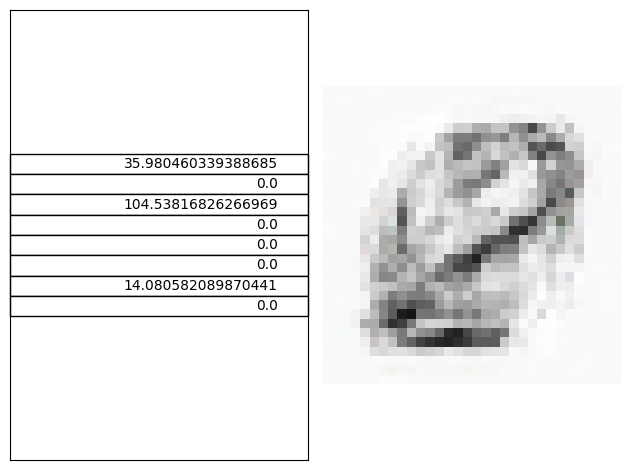

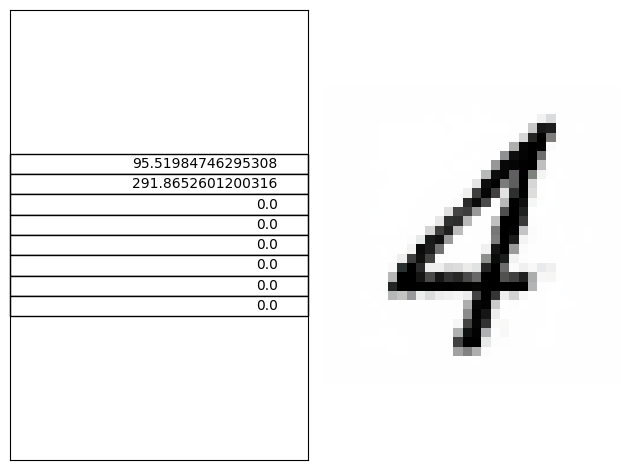

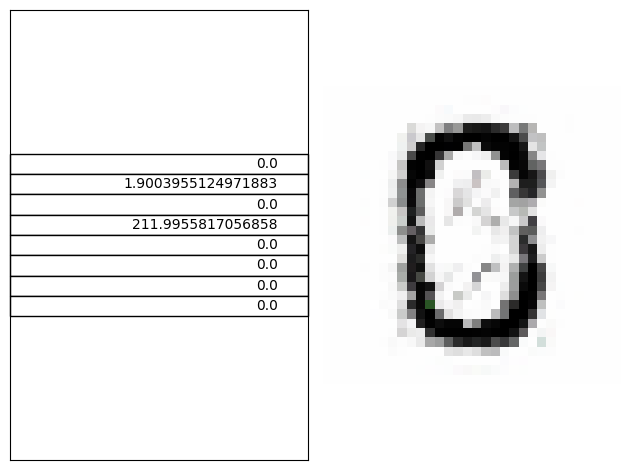

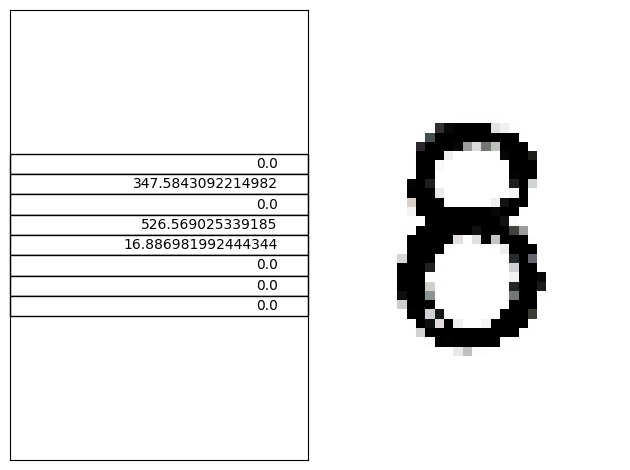

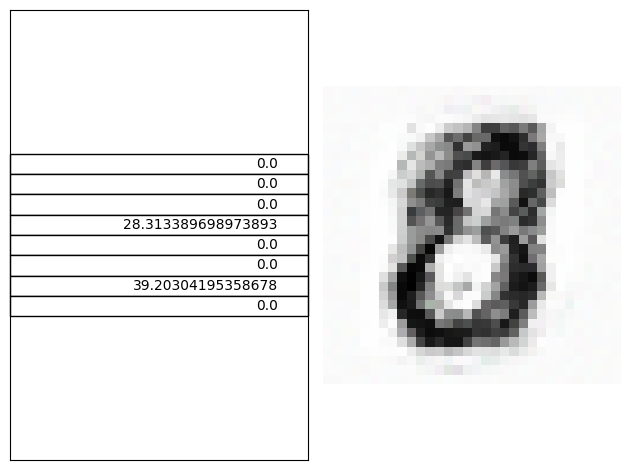

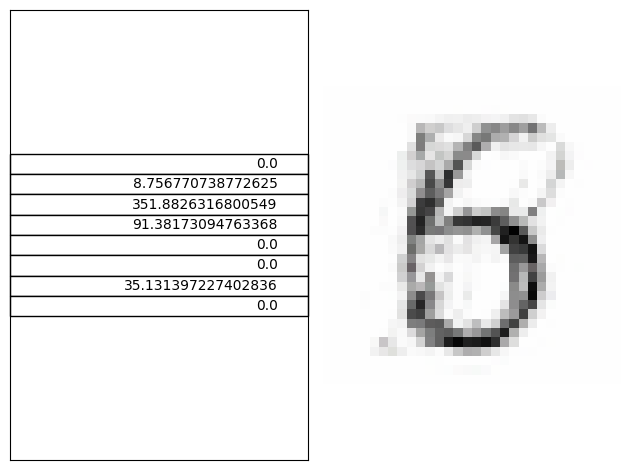

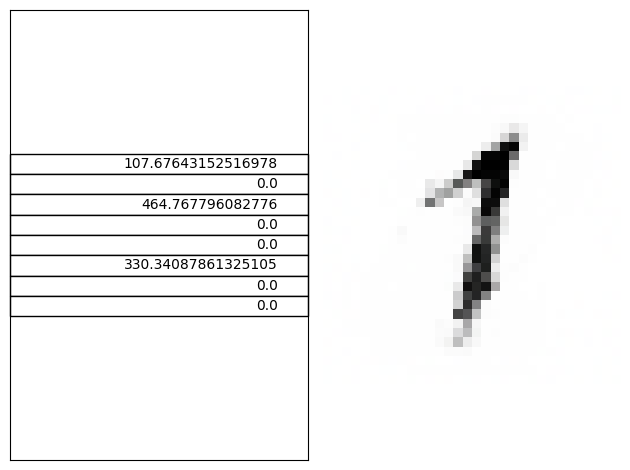

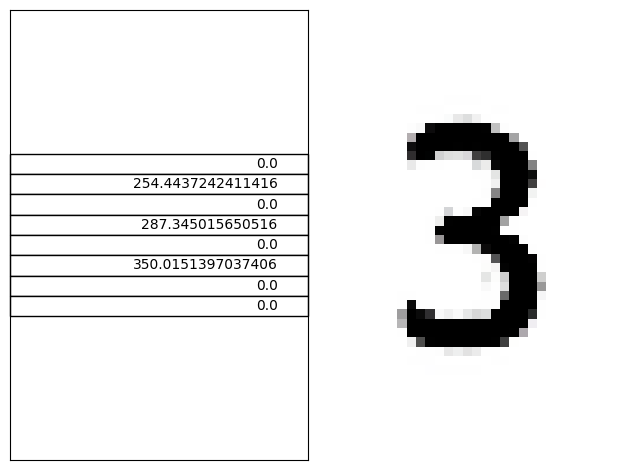

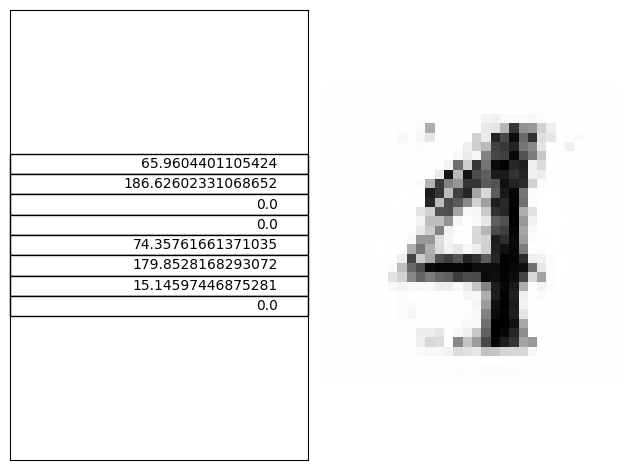

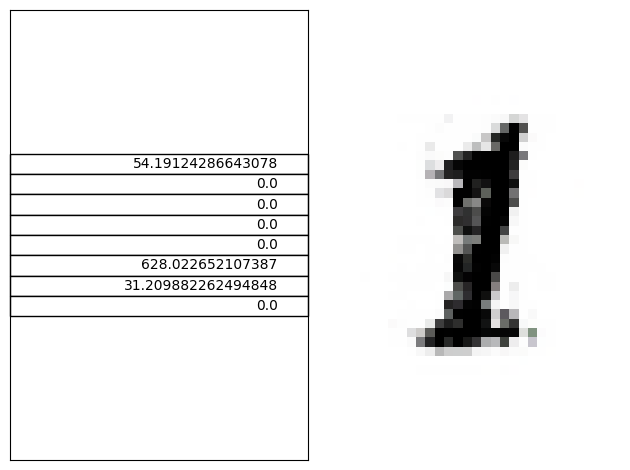

In [19]:
#@title Ejecutar el Generator con Features al Azar
#  usando valores definidos al azar como datos de entrada
cantGenerar = 10 #@param {type:"integer"}

# genera los datos de entrada
# (como la codificación tiene varias posiciones con ceros
# se considera que sólo se ponen al azar entre 10% y el 70% de los valores, el resto queda en cero,
# --sino se podría hacer con " np.random.rand(cantImagenGenerar, num_features) "-- )
arX = []
minRnd = 1
maxRnd = num_features
for i in range(cantGenerar):
  X = np.zeros(num_features)
  for j in range(np.random.randint(low=minRnd, high=maxRnd)):
      pos = np.random.randint(low=0, high=num_features-1)
      # si están definidas las estadisticas las usa, sino no
      if (minArClust is None or  maxArClust is None):
          X[pos] = np.random.uniform()
      else:
          X[pos] = np.random.uniform(minArClust[pos], maxArClust[pos])

  arX.append( X )


# ejecuta el modelo Generator
imagOut = GENmodel.predict( np.array(arX).reshape((len(arX), num_features)) )

# muestra las imágenes generadas
print("\n> Resultados: ")
for i in range(len(arX)):

    fig = plt.figure()

    # muestra los datos
    ax1 = fig.add_subplot(121)
    datosMostrar = arX[i].reshape(num_features, 1)
    ax1.table(cellText=datosMostrar, loc='center')
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)

    #  muestra reconstrucción
    ax2 = fig.add_subplot(122)
    plot_image(imagOut[i])

    plt.tight_layout()
    fig = plt.gcf()


Output()

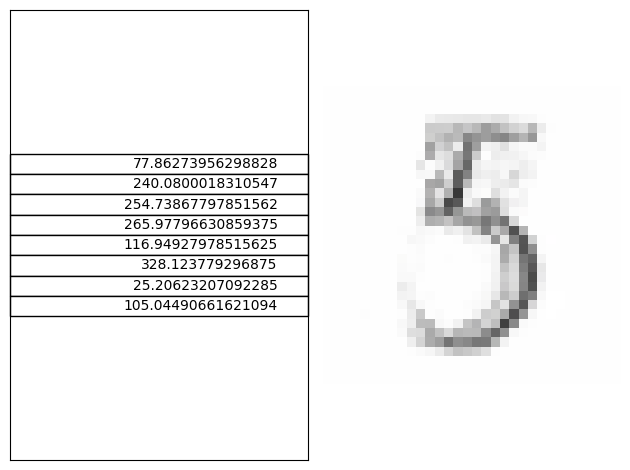

In [20]:
#@title Ejecuta el Generator con Features Personalizados

if colValues is not None and len(colValues) > 0:
  fValueList = []
  for i in range(len(colValues)):

    if (minArClust is None or  maxArClust is None):
        fsMin = -100.0
        fsVal = 0.0
        fsMax = 100.0
    else:
        fsMin = minArClust[i] - 25
        fsVal = ( maxArClust[i] - minArClust[i] ) / 2.0
        fsMax = maxArClust[i] + 25

    fValue = widgets.FloatSlider(
        value=fsVal,
        min=fsMin,
        max=fsMax,
        step=0.1,
        description=colValues[i] + ':',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
      )
    fValueList.append(fValue)

  button = widgets.Button(description="Generar")

  def on_button_clicked(b):
      with out:
          X = []
          for i in range(len(fValueList)):
            X.append( fValueList[i].value )
          X = np.array(X)

          # ejecuta el modelo Generator
          arX= [X]
          imagOut = GENmodel.predict( np.array(arX).reshape((len(arX), num_features)), verbose=0 )

          fig = plt.figure()

          # muestra los datos
          ax1 = fig.add_subplot(121)
          datosMostrar = X.reshape(num_features, 1)
          ax1.table(cellText=datosMostrar, loc='center')
          ax1.get_xaxis().set_visible(False)
          ax1.get_yaxis().set_visible(False)

          #  muestra reconstrucción
          ax2 = fig.add_subplot(122)
          plot_image(imagOut[0])

          plt.tight_layout()
          fig = plt.gcf()

          print("\n")


  button.on_click(on_button_clicked)

  ui = widgets.VBox(fValueList + [button])
  out = widgets.Output()
  display(ui, out)
  print("\n")

